Importing the necessaries

In [52]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig
from sklearn.ensemble import IsolationForest
from datasets import load_dataset
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score
from sklearn.metrics import multilabel_confusion_matrix
from optoolkit import CNNTransformerClassifier
import torch
from safetensors.torch import load_file

Loading the dataset from disk

In [53]:
train_dataset = load_dataset('rootblind/opjustice-dataset', split='train')
test_dataset = load_dataset('rootblind/opjustice-dataset', split='test')

Inspecting data

In [54]:
train_dataset.to_pandas().head()

,Message,OK,Aggro,Violence,Sexual,Hateful
0,mai taci,1,0,0,0,0
1,Cel mai tari om da carry ma carat cu kata sa...,1,0,0,0,0
2,wtf ce smap de bot ratat am vrut sa pun ce fac...,1,0,0,0,0
3,el e in high elo,1,0,0,0,0
4,ai vol iu,1,0,0,0,0


In [55]:
test_dataset.to_pandas().head()

,Message,OK,Aggro,Violence,Sexual,Hateful
0,giorgii,1,0,0,0,0
1,atata timp cat nu dau tag la euneeuw pur si s...,1,0,0,0,0
2,duoq,1,0,0,0,0
3,Ar trebui sa il stii atunci,1,0,0,0,0
4,nu e din ala,1,0,0,0,0


Converting the dataset to pandas for easier analysis

In [56]:
import pandas as pd

df_train = train_dataset.to_pandas()
df_test = test_dataset.to_pandas()

df_train.describe()

,OK,Aggro,Violence,Sexual,Hateful
count,21273.000000,21273.000000,21273.000000,21273.000000,21273.000000
mean,0.525079,0.383632,0.101302,0.179382,0.113994
std,0.499382,0.486281,0.301735,0.383681,0.317812
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [57]:
df_test.describe()

,OK,Aggro,Violence,Sexual,Hateful
count,5306.000000,5306.000000,5306.000000,5306.000000,5306.000000
mean,0.525254,0.385978,0.110441,0.173389,0.115907
std,0.499409,0.486871,0.313468,0.378619,0.320143
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [58]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21273 entries, 0 to 21272
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Message   21273 non-null  object
 1   OK        21273 non-null  int64 
 2   Aggro     21273 non-null  int64 
 3   Violence  21273 non-null  int64 
 4   Sexual    21273 non-null  int64 
 5   Hateful   21273 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 997.3+ KB


In [59]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5306 entries, 0 to 5305
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Message   5306 non-null   object
 1   OK        5306 non-null   int64 
 2   Aggro     5306 non-null   int64 
 3   Violence  5306 non-null   int64 
 4   Sexual    5306 non-null   int64 
 5   Hateful   5306 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 248.8+ KB


In [60]:
df_train.isnull().sum()

Message     0
OK          0
Aggro       0
Violence    0
Sexual      0
Hateful     0
dtype: int64

In [61]:
print('Train shape: ', str(df_train.shape))
print('Test shape: ', str(df_test.shape))

Train shape:  (21273, 6)
Test shape:  (5306, 6)


In [62]:
print(f'Number of duplicated instances in train: {df_train.duplicated().sum()}')
print(f'Number of duplicated instances in test: {df_test.duplicated().sum()}')

Number of duplicated instances in train: 2624
Number of duplicated instances in test: 581


In [63]:
numeric_df = df_train.select_dtypes(include=[np.number])

# Compute the correlation matrix
correlation_matrix = numeric_df.corr()

# Display the correlation matrix
print(correlation_matrix)

                OK     Aggro  Violence    Sexual   Hateful
OK        1.000000 -0.828381 -0.309346 -0.450882 -0.357906
Aggro    -0.828381  1.000000  0.165088  0.303377  0.268500
Violence -0.309346  0.165088  1.000000  0.065957  0.110468
Sexual   -0.450882  0.303377  0.065957  1.000000  0.061297
Hateful  -0.357906  0.268500  0.110468  0.061297  1.000000


Data visualization

In [64]:
import matplotlib.pyplot as plt # importing the neccessary library

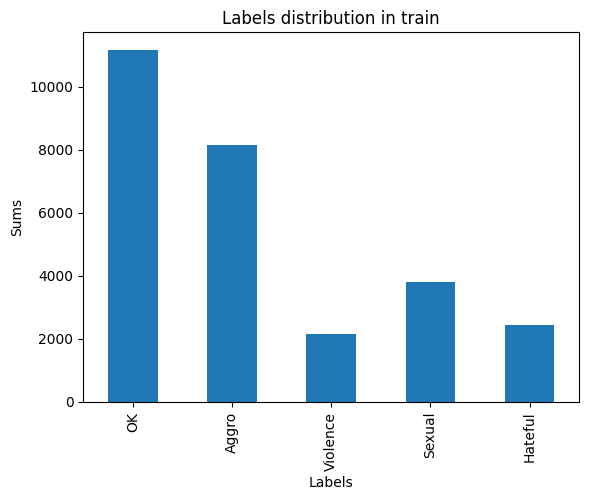

OK          11170
Aggro        8161
Violence     2155
Sexual       3816
Hateful      2425
dtype: int64


In [65]:
columns = df_train.drop(columns='Message')
columns_sums = columns.sum(axis=0)
columns_sums.plot(kind='bar')

plt.title('Labels distribution in train')
plt.ylabel('Sums')
plt.xlabel('Labels')
plt.show()
print(columns_sums)

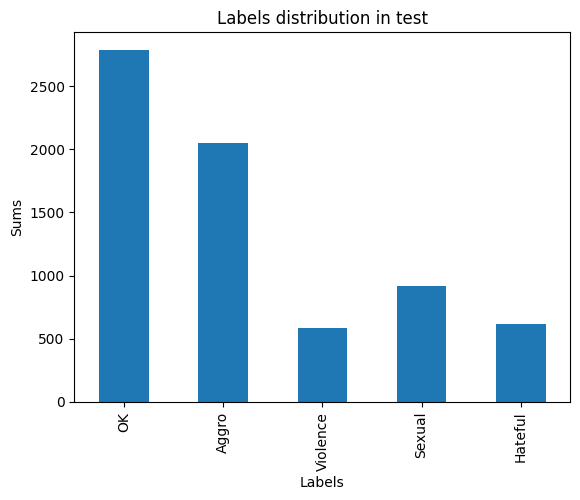

OK          2787
Aggro       2048
Violence     586
Sexual       920
Hateful      615
dtype: int64


In [66]:
columns = df_test.drop(columns='Message')
columns_sums = columns.sum(axis=0)
columns_sums.plot(kind='bar')

plt.title('Labels distribution in test')
plt.ylabel('Sums')
plt.xlabel('Labels')
plt.show()
print(columns_sums)

<Axes: >

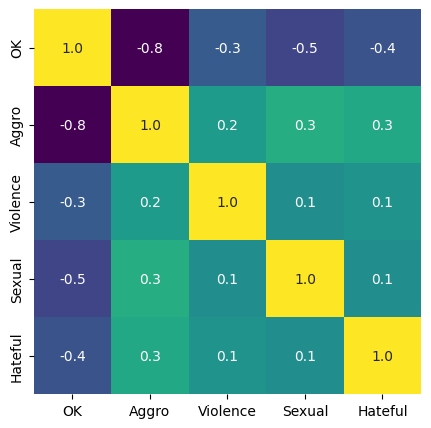

In [67]:
plt.figure(figsize=(5,5))
sns.heatmap(correlation_matrix, annot=True, fmt='.1f', cbar=None,cmap='viridis')

Comparing the train and the test datasets sizes

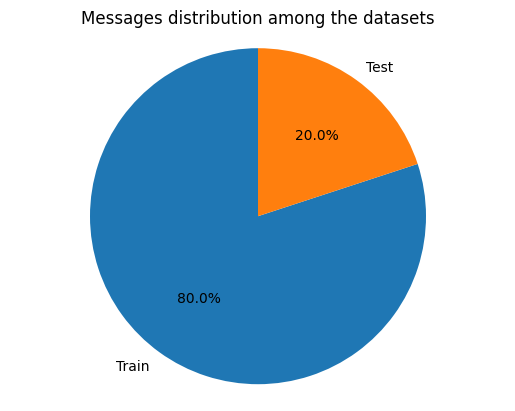

[np.int64(21273), np.int64(5306)]


In [68]:
train_test = ['Train', 'Test']
train_test_size = [df_train['Message'].value_counts().sum(), df_test['Message'].value_counts().sum()]
plt.pie(train_test_size, labels=train_test, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Messages distribution among the datasets')
plt.show()
print(train_test_size)

## Model evaluation

In [69]:
f1_array = []
models_used = ['v4-small']

### My model

In [70]:
class ToxicityDataset:
    def __init__(self, dataset_path='./automod-model/dataset', dataset_name='rootblind/opjustice-dataset'):
        self.dataset_path = dataset_path
        self.dataset_name = dataset_name
        self.dataset = self.load_dataset()
        self.labels = self.get_labels()
        self.id2label, self.label2id = self.create_label_mappings()

    def load_dataset(self):
        dataset = load_dataset(self.dataset_name)
        return dataset

    def get_labels(self):
        return [label for label in self.dataset['train'].features.keys() if label not in 'Message']

    def create_label_mappings(self):
        id2label = {idx: label for idx, label in enumerate(self.labels)}
        label2id = {label: idx for idx, label in enumerate(self.labels)}
        return id2label, label2id

    def preprocess_data(self, examples, tokenizer):
        text = examples["Message"]
        encoding = tokenizer(text, padding="max_length", truncation=True, max_length=512)
        labels_batch = {k: examples[k] for k in examples.keys() if k in self.labels}
        labels_matrix = np.zeros((len(text), len(self.labels)))

        for idx, label in enumerate(self.labels):
            labels_matrix[:, idx] = labels_batch[label]

        encoding["labels"] = labels_matrix.tolist()
        return encoding

    def encode_dataset(self, tokenizer):
        encoded_dataset = self.dataset.map(lambda x: self.preprocess_data(x, tokenizer), batched=True, remove_columns=self.dataset['train'].column_names)
        encoded_dataset.set_format("torch")
        return encoded_dataset

In [71]:
class ToxicityModel:
    def __init__(self, model_name, num_labels, id2label, label2id, device=None):
        self.model_name = model_name
        self.device = device if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = self.load_model(num_labels, id2label, label2id)

    def load_model(self, num_labels, id2label, label2id):
        model = AutoModelForSequenceClassification.from_pretrained(self.model_name, 
                                                                   problem_type="multi_label_classification", 
                                                                   num_labels=num_labels,
                                                                   id2label=id2label,
                                                                   label2id=label2id).to(self.device)
        
        return model

    def predict(self, text, tokenizer):
        encoding = tokenizer(text, return_tensors="pt")
        encoding = {k: v.to(self.device) for k, v in encoding.items()}
        with torch.no_grad():
            outputs = self.model(**encoding)
        
        logits = outputs.logits
        sigmoid = torch.nn.Sigmoid()
        probs = sigmoid(logits.squeeze().cpu())
        predictions = np.zeros(probs.shape)
        predictions[np.where(probs >= 0.5)] = 1
        return predictions

In [72]:
toxicityDataset = ToxicityDataset()
toxicityModel = ToxicityModel(
    model_name='./model_versions/v4', # 8 epochs 32 batch size
    num_labels=len(toxicityDataset.labels),
    id2label=toxicityDataset.id2label,
    label2id=toxicityDataset.label2id
    
    )

In [73]:
tokenizer = AutoTokenizer.from_pretrained('./model_versions/v4')
loaded_dataset = toxicityDataset.load_dataset()
encoded_dataset = toxicityDataset.encode_dataset(tokenizer)

In [74]:
X_test = [sample['Message'] for sample in loaded_dataset['test']]
y_test = [[sample[label] for label in toxicityDataset.labels] for sample in loaded_dataset['test']]

In [75]:
y_pred = [toxicityModel.predict(text, tokenizer) for text in X_test]

In [76]:
f1 = f1_score(y_test, y_pred, average="micro")
precision = precision_score(y_test, y_pred, average="micro")
recall = recall_score(y_test, y_pred, average="micro")
accuracy = accuracy_score(y_test, y_pred)
f1_array.append(f1)
roc_auc = roc_auc_score(y_test, y_pred)
clsr = classification_report(y_test, y_pred, target_names=["OK","Aggro","Violence","Sexual","Hateful"])

print(clsr)
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")

              precision    recall  f1-score   support

          OK       0.93      0.93      0.93      2787
       Aggro       0.92      0.92      0.92      2048
    Violence       0.84      0.87      0.86       586
      Sexual       0.95      0.91      0.93       920
     Hateful       0.89      0.91      0.90       615

   micro avg       0.92      0.92      0.92      6956
   macro avg       0.91      0.91      0.91      6956
weighted avg       0.92      0.92      0.92      6956
 samples avg       0.91      0.92      0.91      6956

F1 Score: 0.9188412048019553
Precision: 0.9189072609633357
Recall: 0.9187751581368603
Accuracy: 0.861100640784018
ROC AUC: 0.9376569750043341


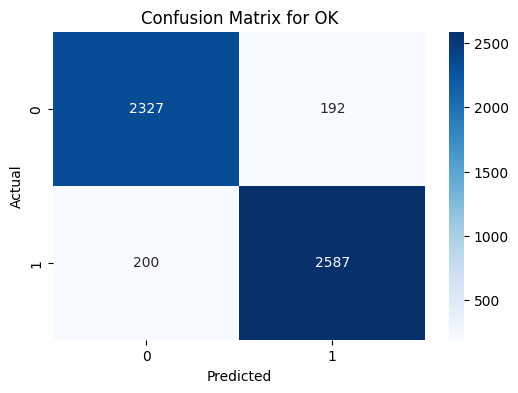

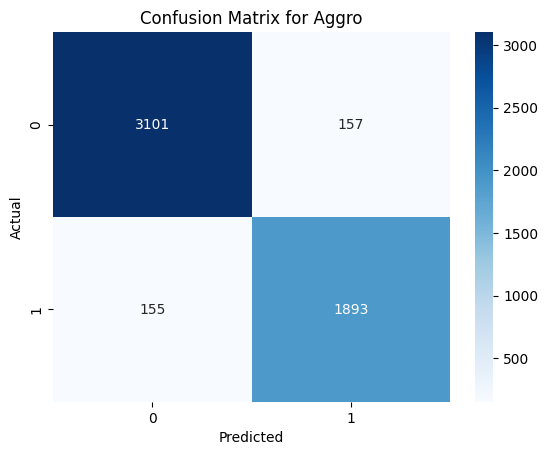

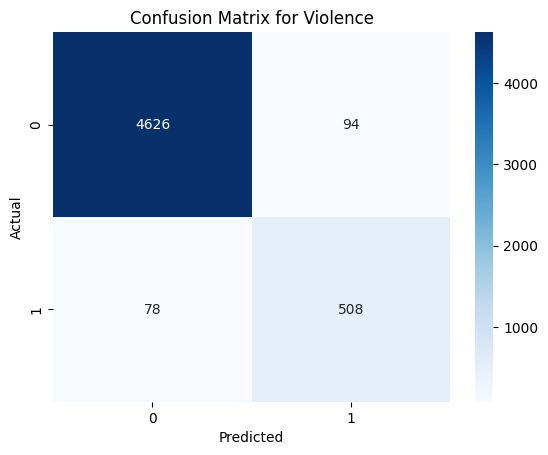

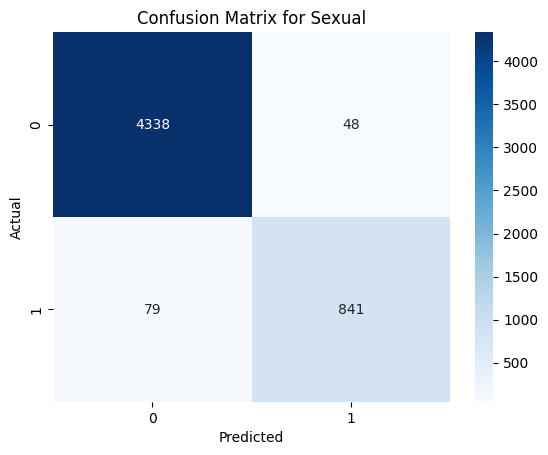

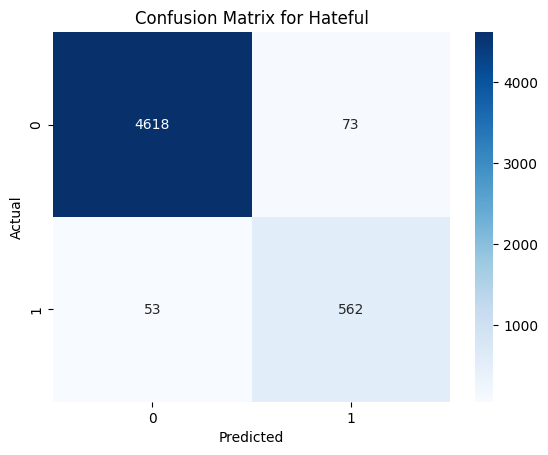

In [77]:
cm = multilabel_confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
label_index = 0
for label in toxicityDataset.labels:
    sns.heatmap(cm[label_index], annot=True, fmt='d', cmap='Blues')
    label_index += 1
    plt.title(f"Confusion Matrix for {label}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

### version 4 - large

In [78]:
dm_tokenizer = AutoTokenizer.from_pretrained("./model_versions/v4-large")

loaded_dataset = toxicityDataset.load_dataset()
encoded_dataset = toxicityDataset.encode_dataset(dm_tokenizer)

X_test = [sample['Message'] for sample in loaded_dataset['test']]
y_test = [[sample[label] for label in toxicityDataset.labels] for sample in loaded_dataset['test']]

dm_model = ToxicityModel(
    model_name='./model_versions/v4-large', # 8 epochs 32 batch size
    num_labels=len(toxicityDataset.labels),
    id2label=toxicityDataset.id2label,
    label2id=toxicityDataset.label2id
    
    )
models_used.append("v4-large")

y_pred = [dm_model.predict(text, dm_tokenizer) for text in X_test]

In [79]:

f1 = f1_score(y_test, y_pred, average="micro")
precision = precision_score(y_test, y_pred, average="micro")
recall = recall_score(y_test, y_pred, average="micro")
accuracy = accuracy_score(y_test, y_pred)
f1_array.append(f1)
roc_auc = roc_auc_score(y_test, y_pred)
clsr = classification_report(y_test, y_pred, target_names=["OK","Aggro","Violence","Sexual","Hateful"])

print(clsr)
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")

              precision    recall  f1-score   support

          OK       0.95      0.93      0.94      2787
       Aggro       0.92      0.94      0.93      2048
    Violence       0.87      0.86      0.87       586
      Sexual       0.95      0.94      0.94       920
     Hateful       0.89      0.92      0.90       615

   micro avg       0.93      0.93      0.93      6956
   macro avg       0.92      0.92      0.92      6956
weighted avg       0.93      0.93      0.93      6956
 samples avg       0.92      0.92      0.92      6956

F1 Score: 0.9277177825773938
Precision: 0.9291895010095184
Recall: 0.9262507188039103
Accuracy: 0.8807010931021485
ROC AUC: 0.9438727628781589


### Setting Xs and ys

In [80]:

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(df_train['Message'])
y_train = df_train.drop(columns='Message')
print(X_train.shape)

(21273, 32524)


In [81]:
X_test = vectorizer.transform(df_test['Message'])
y_test = df_test.drop(columns='Message')

X_test.shape

(5306, 32524)

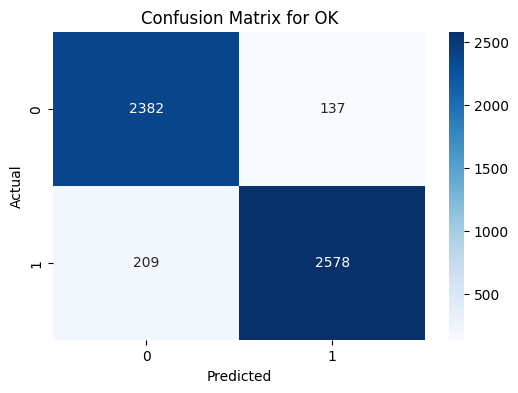

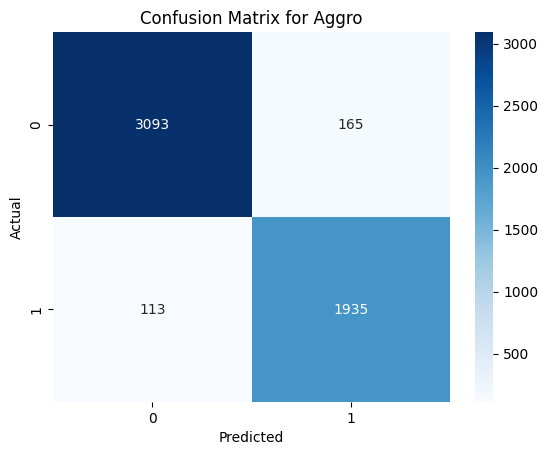

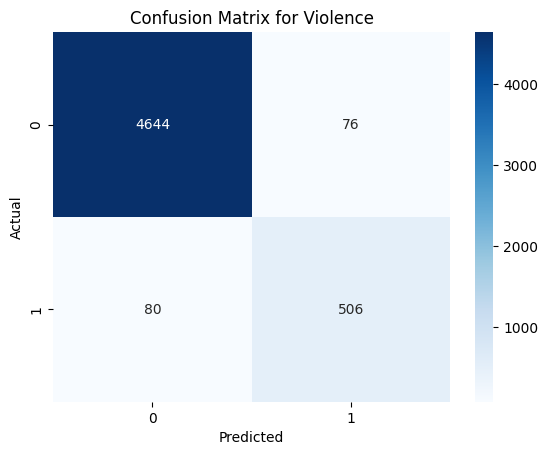

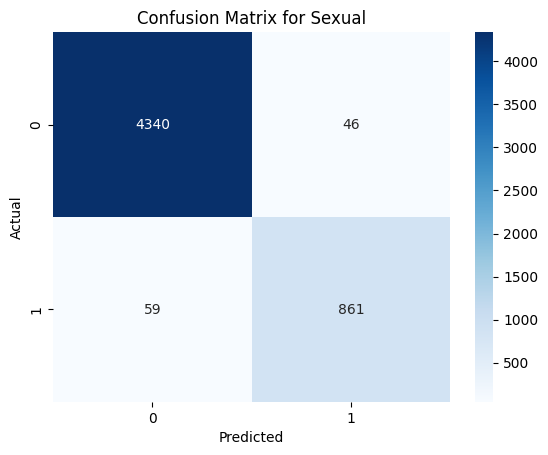

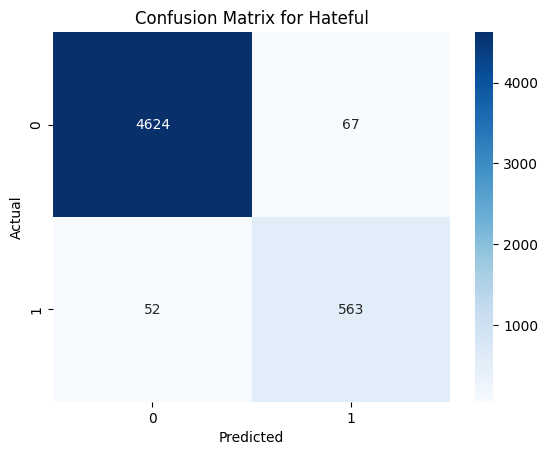

In [82]:
cm = multilabel_confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
label_index = 0
for label in toxicityDataset.labels:
    sns.heatmap(cm[label_index], annot=True, fmt='d', cmap='Blues')
    label_index += 1
    plt.title(f"Confusion Matrix for {label}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

### v4-cnn

In [83]:
tokenizer_cnn = AutoTokenizer.from_pretrained("./model_versions/v4-cnn")

loaded_dataset = toxicityDataset.load_dataset()
encoded_dataset = toxicityDataset.encode_dataset(tokenizer_cnn)

X_test = [sample['Message'] for sample in loaded_dataset['test']]
y_test = [[sample[label] for label in toxicityDataset.labels] for sample in loaded_dataset['test']]


In [84]:
config = AutoConfig.from_pretrained("./model_versions/v4-cnn", _name_or_path="./model_versions/v4-cnn", num_labels=5)
model_cnn = CNNTransformerClassifier(config).to(torch.device("cuda"))
state_dict = load_file(f"./model_versions/v4-cnn/model.safetensors")
model_cnn.load_state_dict(state_dict)

Some weights of BertModel were not initialized from the model checkpoint at ./model_versions/v4-cnn and are newly initialized: ['embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.l

<All keys matched successfully>

In [85]:
models_used.append("v4-cnn")

y_pred = [model_cnn.predictions(text, tokenizer_cnn) for text in X_test]

In [86]:
f1 = f1_score(y_test, y_pred, average="micro")
precision = precision_score(y_test, y_pred, average="micro")
recall = recall_score(y_test, y_pred, average="micro")
accuracy = accuracy_score(y_test, y_pred)
f1_array.append(f1)
roc_auc = roc_auc_score(y_test, y_pred)
clsr = classification_report(y_test, y_pred, target_names=["OK","Aggro","Violence","Sexual","Hateful"])

print(clsr)
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")

              precision    recall  f1-score   support

          OK       0.95      0.90      0.92      2787
       Aggro       0.89      0.93      0.91      2048
    Violence       0.67      0.75      0.71       586
      Sexual       0.90      0.85      0.87       920
     Hateful       0.82      0.84      0.83       615

   micro avg       0.89      0.88      0.88      6956
   macro avg       0.85      0.85      0.85      6956
weighted avg       0.89      0.88      0.89      6956
 samples avg       0.89      0.89      0.88      6956

F1 Score: 0.883989047413172
Precision: 0.8861600693441202
Recall: 0.881828637147786
Accuracy: 0.7957029777610253
ROC AUC: 0.904594992488791


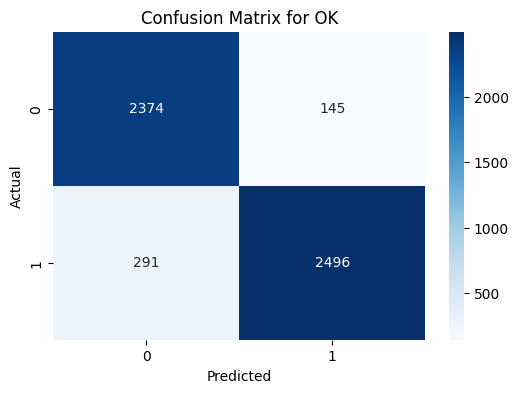

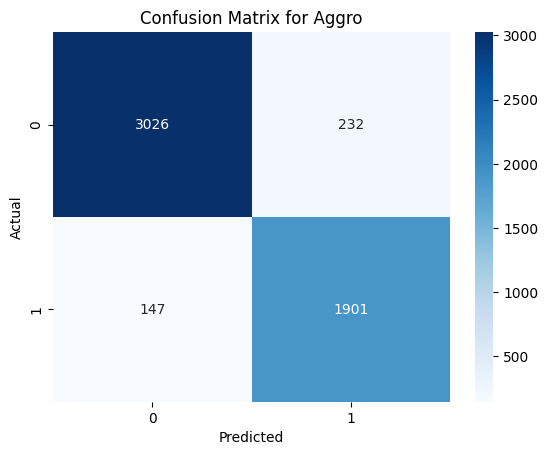

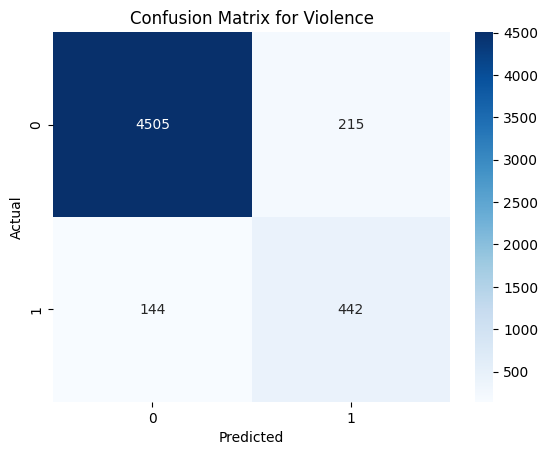

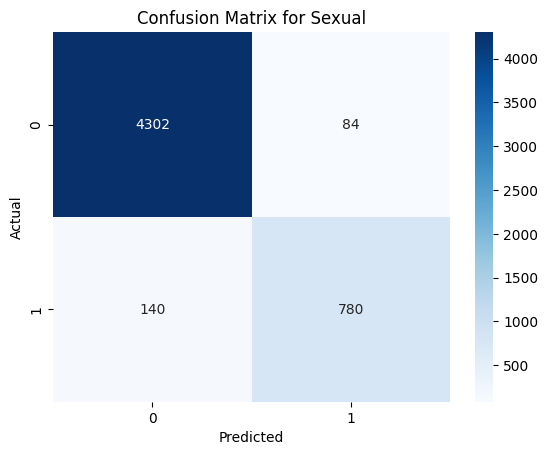

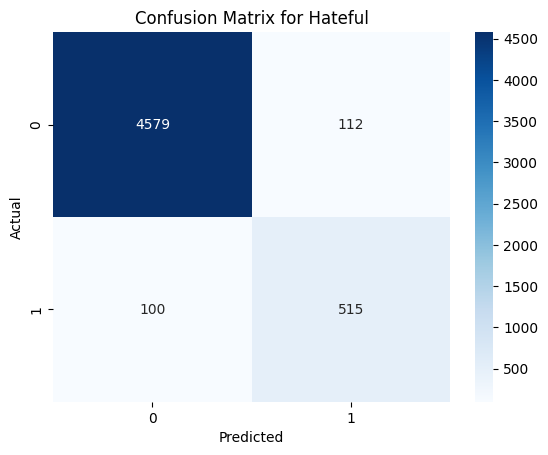

In [87]:
cm = multilabel_confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
label_index = 0
for label in toxicityDataset.labels:
    sns.heatmap(cm[label_index], annot=True, fmt='d', cmap='Blues')
    label_index += 1
    plt.title(f"Confusion Matrix for {label}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

### Isolation Forest

In [88]:
clf =  IsolationForest(n_estimators=50, max_samples="auto", random_state=42, contamination=float(0.1))

from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X_train_2d = pca.fit_transform(X_train.toarray())

clf.fit(X_train_2d)

IsolationForest(contamination=0.1, n_estimators=50, random_state=42)

In [89]:
df_train['scores'] = clf.decision_function(X_train_2d)
df_train['anomaly'] = clf.predict(X_train_2d)

df_train.head(20)

,Message,OK,Aggro,Violence,Sexual,Hateful,scores,anomaly
0,mai taci,1,0,0,0,0,0.081212,1
1,Cel mai tari om da carry ma carat cu kata sa...,1,0,0,0,0,0.032342,1
2,wtf ce smap de bot ratat am vrut sa pun ce fac...,1,0,0,0,0,0.120973,1
3,el e in high elo,1,0,0,0,0,0.134998,1
4,ai vol iu,1,0,0,0,0,0.119921,1
5,player exceptional,1,0,0,0,0,0.158965,1
6,a durat cv,1,0,0,0,0,0.162305,1
7,Same,1,0,0,0,0,0.156058,1
8,de unde stii ca i fata,1,0,0,0,0,0.114481,1
9,rateaz q ul ca tine,1,0,0,0,0,0.117988,1


In [90]:
anomaly = df_train.loc[df_train['anomaly'] == -1]
anomaly_index = list(anomaly.index)
print(anomaly)

                                                 Message  OK  Aggro  Violence  \
15                                   Am laptopul stricat   1      0         0   
23                                                  n am   1      0         0   
26                                   am luat si eu pauza   1      0         0   
41                                       joaca bine vafa   1      0         0   
47                                           ti am zis o   1      0         0   
...                                                  ...  ..    ...       ...   
21198                       eu si tu nu ai jucat sprijin   1      0         0   
21199  dovada care arata foarte bine pe care trebuie ...   1      0         0   
21206                              rep baiatu joaca bine   1      0         0   
21230  ei bine nu trebuie sa spuneti ca daca faceti o...   1      0         0   
21272                             eu sau am intarziat ed   0      0         0   

       Sexual  Hateful    s

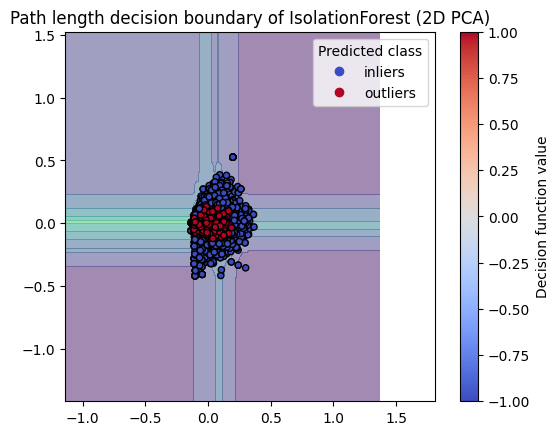

In [91]:
disp = DecisionBoundaryDisplay.from_estimator(
    clf,
    X_train_2d,
    response_method="decision_function",
    alpha=0.5,
)

y_pred = clf.predict(X_train_2d)  # -1 for outliers, 1 for inliers
scatter = disp.ax_.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_pred, cmap="coolwarm", s=20, edgecolor="k")

disp.ax_.set_title("Path length decision boundary of IsolationForest (2D PCA)")
plt.axis("square")

# Legend for predicted classes
plt.legend(handles=scatter.legend_elements()[0], labels=["inliers", "outliers"], title="Predicted class")

# Add a color bar for the decision boundary
plt.colorbar(disp.ax_.collections[1], ax=disp.ax_, label="Decision function value")

plt.show()

df_train.drop(columns=['scores', 'anomaly'], inplace=True)

## Comparing accuracy between algorithms

<BarContainer object of 3 artists>

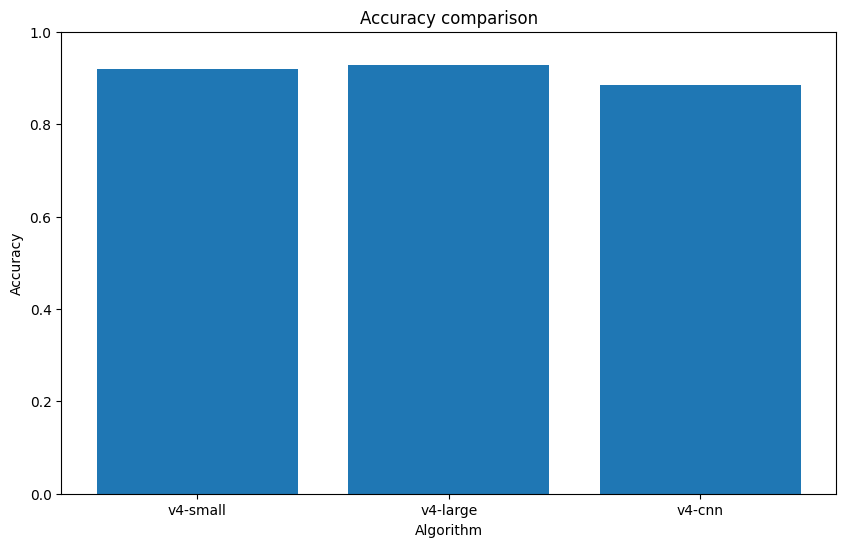

In [93]:
plt.figure(figsize=(10,6))
plt.title('Accuracy comparison')
plt.xlabel('Algorithm')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.bar(models_used, f1_array)

It takes over 8GB of RAM just to fit the model, run this cell when you don't need your computer for several minutes.

In [ ]:
"""
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
kernel = DotProduct() + WhiteKernel()
model = GaussianProcessRegressor(kernel=kernel, random_state=42)

model.fit(X_train.toarray(), y_train)
y_pred = model.predict(X_test.toarray())
y_pred_binary = (y_pred > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred_binary)
accuracy_array.append(accuracy)
models_used.append('GPR')
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred_binary))
"""

"\nfrom sklearn.gaussian_process.kernels import DotProduct, WhiteKernel\nkernel = DotProduct() + WhiteKernel()\nmodel = GaussianProcessRegressor(kernel=kernel, random_state=42)\n\nmodel.fit(X_train.toarray(), y_train)\ny_pred = model.predict(X_test.toarray())\ny_pred_binary = (y_pred > 0.5).astype(int)\naccuracy = accuracy_score(y_test, y_pred_binary)\naccuracy_array.append(accuracy)\nmodels_used.append('GPR')\nprint(f'Accuracy: {accuracy:.2f}')\nprint(classification_report(y_test, y_pred_binary))\n"